0.5 + 0.35*dfc["indulgence_scaled"] - 0.1*dfc["tenaciousness_scaled"] - 0.1*dfc["elongation"] - 0.1*dfc["inconvenience"] - 0.08*dfc["pitching_team_hype"] + 0.08*dfc["batting_team_hype"]


In [76]:
import load

df = load.data("groundout_formulas", season=18)

#df = df[df['event_type']=='Sac']
#df = df[df['event_type']=='DP']
#df = df[df['event_type']=="advance_0"]
#df = df[df['event_type']=="advance_1"]
df = df[df['event_type']=="advance"]

df["indulgence_scaled"] = load.player_attribute(df, 'relevant_runner', 'indulgence', vibes=True, mods=True, items=True, broken_items=True)

df["tenaciousness_scaled"] = load.player_attribute(df, 'fielder', 'tenaciousness', vibes=True, mods=True, items=True, broken_items=True)

df["elongation"] = load.stadium_attribute(df, 'elongation', center=True)
df["inconvenience"] = load.stadium_attribute(df, 'inconvenience', center=True)

In [77]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

pd.set_option("display.max_rows", 60)  # default 60
pd.set_option("display.max_columns", 20)  # default 20

In [149]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    
dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

len(dfc)

1886

In [179]:
X = dfc[
    [
        "roll",
        "passed",
        "indulgence_scaled",
        "tenaciousness_scaled",
        "inconvenience",
        "elongation",
        #"batting_team_hype",
        #"pitching_team_hype"


    ]
].copy()
#X = X[X["roll"] > 0.001]
y = X["passed"]
X = X.drop(["passed"], axis=1)

pin_intercept = 0.5
pins = [ (0.35, "indulgence_scaled"),  
(-0.1, "tenaciousness_scaled"),
(-0.1, "elongation"),
(-0.1, "inconvenience"),
#(-0.1, "hypediff")
]

for val, var in pins:
    X["roll"] -= X[var] * val
    X = X.drop(var, axis=1)

sc = StandardScaler(with_mean=False)
X2 = sc.fit_transform(X)
if pin_intercept is not None:
    X2[:, 0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(
    dual=False, max_iter=10000000, C=100000000, tol=1e-15, fit_intercept=pin_intercept is None
).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0, 1] + confusion_matrix(y, predictionsvm)[1, 0], "outliers")
print(trainedsvm.score(X2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_   #- np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[[ 481   24]
 [  24 1357]]
48 outliers
0.9745493107104984
0.5


[(1.0, 'roll')]

In [176]:

dfc["threshold"] = 0.5 + 0.35*dfc["indulgence_scaled"] - 0.1*dfc["tenaciousness_scaled"] - 0.1*dfc["elongation"] - 0.1*dfc["inconvenience"]

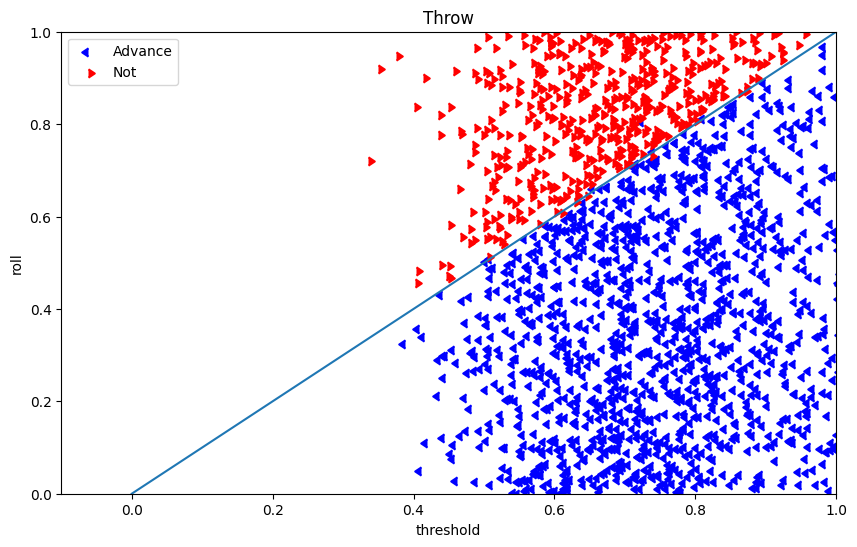

In [177]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Advance", marker=CARETLEFTBASE)
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="Not", marker=CARETRIGHTBASE)
ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Throw")
ax.set_xlim([-0.1, 1])
ax.set_ylim([0.0, 1.0])
ax.legend()

,offset,event_type,roll,threshold,batter_name,pitcher_name,weather,fielder_name,season,batting_team_mods,batter_mods,pitcher_mods,fielder_mods,pitching_team_mods,day,game_id,play_count
2453,-0.004376,advance,0.730817,0.735193,Lenny Spruce,Greer Lott,Weather.FLOODING,Lucien Patchwork,18,GROWTH,,NEGATIVE;ALTERNATE,SLOW_BUILD,H20;HIGH_PRESSURE,30,af26c450-245a-4088-b3a5-65e1313eddc7,44
5498,-0.000381,advance,0.607099,0.607480,Ortiz Lopez,Mohammed Picklestein,Weather.REVERB,Dudley Mueller,18,UNDERSEA,FIRE_EATER,REPEATING,SCATTERED;SIPHON,PSYCHIC,70,b6828ea0-99c5-4a52-9e95-75af276aa00b,239
2427,0.002843,advance,0.659617,0.656774,James Mora,Baldwin Breadwinner,Weather.BLACK_HOLE,Kline Greenlemon,18,O_NO,EGO2,PARASITE;ALTERNATE,MAXIMALIST,AAA,29,bfa19dee-11ee-4154-a5fc-f3c51feac969,277
755,0.077466,advance,0.803703,0.726237,Phineas Wormthrice,Caleb Alvarado,Weather.COFFEE,Peanutiel Duffy,18,BASE_INSTINCTS,,FRIEND_OF_CROWS,HONEY_ROASTED,,12,869377ea-224f-47e9-932f-aa8c486fbd66,240


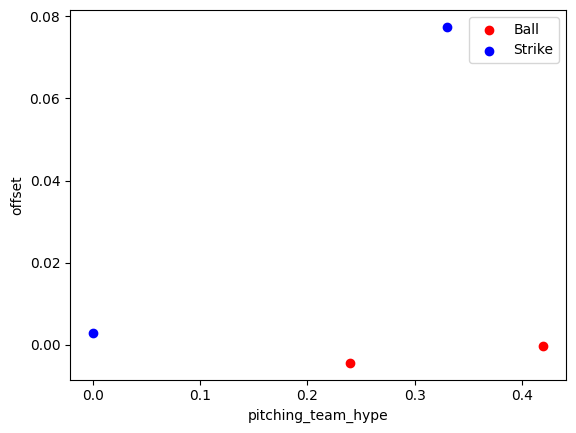

In [178]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]
#outliers = outliers[outliers["roll"] > 0.001]


fig, ax = plt.subplots(1)
x_val = "pitching_team_hype"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Ball")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Strike")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "event_type",
       "roll", "threshold", 
       "batter_name", "pitcher_name", "weather", "fielder_name", "season", "batting_team_mods", "batter_mods", "pitcher_mods", "fielder_mods", "pitching_team_mods",
       "day",  "game_id", "play_count"]].sort_values('offset')


In [43]:
print(dfc[dfc["passed"]]["roll"].max())
print(dfc[~dfc["passed"]]["roll"].min())

0.5408178948511813
0.0014721651687263915
